In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [8]:
def is_inside_qpd(qpd_diameter):
    r = (xg**2 + yg**2)**0.5
    return r <= qpd_diameter / 2

def is_in_quadrant(quadrant_id):
    g = qpd_gap / 2
    if quadrant_id == 1:
        return (xg < -g) & (yg > g)
    elif quadrant_id == 2:
        return (xg > g) & (yg > g)
    elif quadrant_id == 3:
        return (xg > g) & (yg < -g)
    elif quadrant_id == 4:
        return (xg < -g) & (yg < -g)
    else:
        return 0

def is_inside_beam(beam_pos, beam_diameter):
    bx = beam_pos[0]
    by = beam_pos[1]
    r = ((xg - bx)**2 + (yg - by)**2)**0.5
    return r <= beam_diameter / 2

def integrate_quadrants(beam_pos, beam_diameter):
    q_count = np.zeros(4)
    for i in range(0, 4):
        quadrant_id = i + 1
        q_count[i] = np.sum(is_inside_beam(beam_pos, beam_diameter) & is_inside_qpd(qpd_diameter) & is_in_quadrant(quadrant_id))
    return q_count
        
def calc_qpd_outputs(q_count):
    Q1 = q_count[0]
    Q2 = q_count[1]
    Q3 = q_count[2]
    Q4 = q_count[3]
    Xdiff = (Q2 + Q3) - (Q4 + Q1)
    Ydiff = (Q1 + Q2) - (Q3 + Q4)
    SUM = Q1 + Q2 + Q3 + Q4
    return Xdiff, Ydiff, SUM

def normalise_qpd(Xdiff, Ydiff, SUM):
    X = Xdiff / SUM
    Y = Ydiff / SUM
    return X, Y

def evaluate_qpd(beam_pos, beam_diameter):
    q_count = integrate_quadrants(beam_pos, beam_diameter)
    Xdiff, Ydiff, SUM = calc_qpd_outputs(q_count)
    X, Y = normalise_qpd(Xdiff, Ydiff, SUM)
    return X, Y, SUM

In [4]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xg, yg = np.meshgrid(x, y)

qpd_diameter = 7.8 # [mm]
qpd_gap = 0 # mm

In [9]:
beam_pos = (0, 0)
beam_diameter = 8
X, Y, SUM = evaluate_qpd(beam_pos, beam_diameter)
print(X, Y, SUM)

[1194. 1155. 1194. 1230.]
-0.01571338780641106 -0.01571338780641106 4773.0


In [34]:
beam_diameter = 8

bx_array = np.arange(-5, 5, 0.1)
by_array = np.zeros_like(bx_list)

qpd_X = np.zeros_like(by_list)
qpd_Y= np.zeros_like(by_list)
qpd_SUM = np.zeros_like(by_list)

for i in range(len(bx_list)):
    beam_pos = (bx_list[i], by_list[i])
    qpd_X[i], qpd_Y[i], qpd_SUM[i] = evaluate_qpd(beam_pos, beam_diameter)


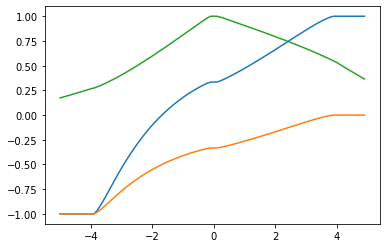

In [35]:
plt.plot(bx_array, qpd_X)
plt.plot(bx_array, qpd_Y)
plt.plot(bx_array, qpd_SUM/np.max(qpd_SUM))

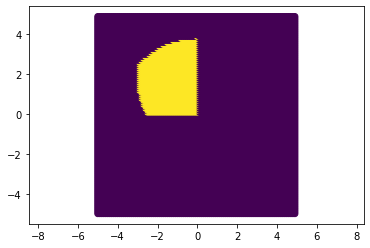

In [48]:
plt.scatter(xg, yg, c=a)
plt.axis('equal')
plt.show()